# Model Solution for Part 2 Lab 2

Written by Charlie Watson (dch.watson@gmail.com) for University of Victoria MATH/PHYS 248 Winter 2018.

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

x = sp.Symbol('x')

## Part A

### Newton's Method


#### Pseudocode

Possible pseudocode for Newton's method:

1. Set `xi` to a starting value.
2. Plug `xi` into $x - \frac{f(x)}{f'(x)}$ to get next value for `xi`.
3. If formula fails because derivative is zero, raise exception or return `NaN`.
4. If `f(xi)` is close enough to zero, stop and return `xi`.
5. If loop has continued too long, raise exception or return `NaN`.
6. Return to step 2.

Arguments must include:

* A function of one variable
* A starting value

Arguments _should_ include

* A tolerance within which to consider a root found
* A maximum number of iterations

#### Code Considerations

##### How to decide if `f` is close to zero?

This one is pretty easy. $f(x)$ is close to zero if $\left\lvert f(x) \right\rvert < \epsilon$ for some small number $\epsilon$. In Python I can write this as

```python
if abs(f(xi)) < tol:
```

where `tol` is the tolerance.

##### Which sort of loop?

I have to choose which sort of loop to use in my function. I've stated before the rule-of-thumb

> If you know how many times the loop will run, use a `for` loop. If you don't, use a `while` loop.

However, this loop is a bit of both. I don't know exactly how many times it will run before converging, but I am setting a _maximum_ number of iterations. There's no perfect rule for this sort of situation, but I'm going to use a `for` loop with a `break` statement. It will look like

```python
for i in range(maximum_iterations):
    xi = something
    
    if abs(f(xi)) < tol:
        break
```

The `break` statement forces the program to exit the `for` loop early. An alternative with a `while` loop would look like

```python
i = 0

while abs(f(xi)) >= tol:
    xi = something
    i += 1
    
    if i >= maximum_iterations:
        break
```

The method with a `for` loop is cleaner. The `for` loop also protects you from a serious error: if you forget `i += 1` in the `while` loop, your function could enter an infinite loop!

##### How to check for a zero denominator?

There are two ways to handle this:

* An explicit check for $f'(x_i) = 0$
* A `try-except` block

An explicit check for a zero denominator could look like:

```python
f_deriv = sp.lambdify(x, f(x).diff(x))

if f_deriv(xi) == 0:
    xi = np.nan
    break
```

I've chosen to return NumPy's NaN (Not A Number) as it will make it easier to ignore bad starting values later. In general the better option is often to raise an [exception](https://docs.python.org/3/tutorial/errors.html) (such as a `ValueError`).

I could also use Python's [exception system](https://docs.python.org/3/tutorial/errors.html) to catch _any_ arithmetic errors that crop up in Newton's method with a `try-except` block, but that's a more advanced topic. Feel free to ask me in lab or office hours if no one has other questions.

##### What to Do if it Runs for Too Long?

If Newton's Method does converge within the maximum number of iterations, then the `for` loop will exit normally. The easy and correct way to handle this in Python is with the [`for` loop's `else` clause](https://docs.python.org/2/tutorial/controlflow.html#break-and-continue-statements-and-else-clauses-on-loops). Any code in the `else` clause will run _only if_ the `for` loop wasn't ended early with a `break` statement.

#### Code For Newton's Method

In [2]:
def newtons_method(f, start, tol=1E-3, max_iters=20):
    """Approximate a root using Newton's method.
    
    Arguments:
        f:         A SymPy function of one variable.
        start:     A starting point for iteration.
        tol:       Maximum distance from zero to consider converged.
        max_iters: Maximum number of iterations to allow.
    
    Returns:
        An approximation of a root of f, or numpy.nan if convergence fails.
    """
    # Local name for the variable in f.
    x = sp.Dummy('x')
    
    # The iteration in Newton's method, described above.
    next_step = sp.lambdify(x, x - f(x) / sp.diff(f(x), x))
    
    # The derivative of f. Will be used to avoid division by zero.
    # diff returns an expression, not a function, so lambdify is needed again.
    f_deriv = sp.lambdify(x, f(x).diff(x))
    
    # The root approximation in the current iteration.
    xi = start
    
    for i in range(max_iters):
        # Check that derivative is not zero, so next x-value is defined.
        if f_deriv(xi) == 0:
            xi = np.nan
            break
        
        xi = next_step(xi)
        
        # End iteration if new approximation is close enough to a root.
        # SymPy has an Abs function, but it's an alias for Python's abs.
        if abs(f(xi)) <= tol:
            break
    # If the for loop ran to completion, then the function never got close enough to zero to be a root.
    else:
        xi = np.nan
        
    return xi

#### Tests for Newton's Method

Check if it correctly finds $\sqrt{2}$ for $x^2-2$.

In [3]:
f = sp.lambdify(x, x**2-2)
abs(newtons_method(f, 1) - 2**(1/2))

2.1239014147411694e-06

That is definitely within $10^{-3}$ of $\sqrt{2}$. What about $\pi$ for $\sin(x)$?

In [4]:
abs(newtons_method(sp.sin, 3, tol=1E-8) - np.pi)

2.8931612661153849e-10

Once again, the returned value is within the required tolerance.

Newton's Method _should not_ converge for $x^2-2$ if it starts at 0.

In [5]:
f = sp.lambdify(x, x**2-2)
newtons_method(f, 0)

nan

Newton's Method _should not_ converge for $x^2+1$, as it has no (real) roots.

In [6]:
f = sp.lambdify(x, x**2 + 1)
newtons_method(f, 0)

nan

### Plotting Basins of Attraction

#### Vectorizing newtons_method

To generate the plot I could write a `for` loop that runs `newtons_method` for every value in some interval. However, NumPy has something to do that for me: `vectorize`. However, if I run

```python
newtons_method = np.vectorize(newtons_method)
```

I won't get what I want, because I only want to transform the _second_ argument. I can do that with the `excluded` argument of `vectorize`. I want to exclude the first positional argument (`f`, at index 0) and the two keyword arguments `tol` and `max_iters`.

In [7]:
newtons_method = np.vectorize(newtons_method, excluded=[0, 'tol', 'max_iters'])

One note of caution! `newtons_method` will now _always_ return a NumPy array.

In [8]:
f = sp.lambdify(x, x**2 - 2)
newtons_method(f, 1)

array(1.4142156862745099)

I can test it with $x(x-1)(x+1)$.

In [9]:
f = sp.lambdify(x, x*(x-1)*(x+1))
newtons_method(f, np.linspace(-2, 2, 10), tol=1E-7)

array([ -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
        -1.00000003e+00,   8.05327755e-14,  -8.05327755e-14,
         1.00000003e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00])

#### Code Basin Plots

The code is now fairly straightforward, since the vectorized `newtons_method` does most of the work for us. Simply generate the x-values, run `newtons_method`, plot the function, and plot the roots.

In [10]:
def plot_roots(f, a, b, n=100):
    """Create and show a plot of f and its attracting roots at various points.
    
    Arguments:
        f: A SymPy function of one variable.
        a: The left end-point of the interval.
        b: The right end-point of the interval
        n: The number of points to sample in the interval.
    """
    # The x-values to run Newton's Method with.
    roots_interval = np.linspace(a, b, n)
    # The x-values for the plot of f.
    plot_interval = np.linspace(a, b, 100)
    
    # The roots to which each x-value converges.
    roots = newtons_method(f, roots_interval)
    
    # Graph of f
    plt.plot(plot_interval, [f(xi) for xi in plot_interval], 'r-')
    # Attracting roots
    plt.plot(roots_interval, roots, 'bo', markersize=0.5)
    # Visible x-axis to show roots.
    plt.plot([a, b], [0, 0], 'black')
    # Uncluttered x-axis.
    plt.xticks(np.linspace(a, b, 5))
    plt.show()

#### Testing plot_roots

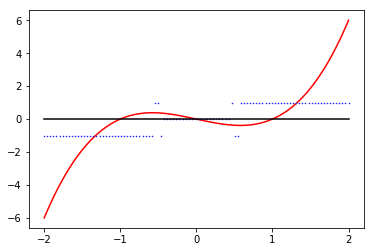

In [11]:
f = sp.lambdify(x, x * (x-1) * (x+1))
plot_roots(f, -2, 2)

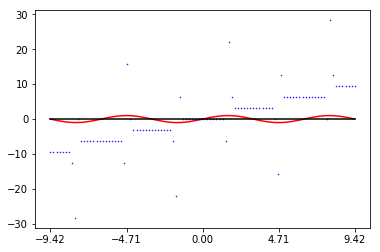

In [12]:
plot_roots(sp.sin, -3*np.pi, 3*np.pi)

This one looks a bit strange. The roots are very high and low because Newton's Method doesn't converge to the root you'd expect when it starts near a critical point of $\sin$. To compensate for this I could vertically squash the root plot. A common and easy way to squash values into a small interval is $\arctan$, since it is smooth, bijective, and has a bounded range (i.e. $(-\frac{\pi}{2}, \frac{\pi}{2})$).

I could simply change the root plotting line of `plot_roots` to

```python
plt.plot(roots_interval, np.arctan(roots), 'bo', markersize=0.5)
```

Alternatively, I could discard roots that lie outside of the interval $[a, b]$.

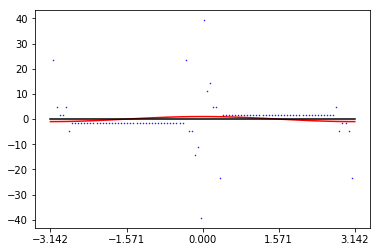

In [13]:
plot_roots(sp.cos, -np.pi, np.pi)

This plot shows the problem even more severely.

## Part B

### Pseudocode

1. Generate a 2D array of complex numbers to start Newton's Method with.
2. Run Newton's method on each of those complex numbers and store the results.
3. For each result
    1. Find the closest true root
    2. Colour the corresponding pixel according the true root
4. Create an image with the given grid of colours.

### Generating Complex Domains

It's easy to create a list of evenly spaced real numbers with NumPy: just use `linspace`. It's not much harder to make a similar 2D grid, but there's no built-in for it.

First create the x- and y-coordinates with `meshgrid` or `mgrid` (`meshgrid` if you want to specify the coordinates manually, `mgrid` if you want to specify them like a slice). Second add the x-coordinates plus $i$ times the y-coordinates. If you haven't used `mgrid`, see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html).

In [14]:
def complex_space(real_min, real_max, imag_min, imag_max, real_n, imag_n):
    """A 2D NumPy array of complex numbers, evenly spaced along each axis.
    
    Arguments:
        real_min: Minimum value along the real axis.
        real_max: Maximum value along the real axis.
        imag_min: Minimum value along the imaginary axis.
        imag_max: Maximum value along the imaginary axis.
        real_n:   Number of points along the real axis.
        imag_n:   Number of points along the imaginary axis.
        
    Returns:
        A (real_n, imag_n)-shaped NumPy array of complex numbers.
    """
    # The imaginary part goes from max to min because matrix indices increase downwards,
    # but Cartesian coordinates increase upwards.
    xs, ys = np.mgrid[real_min:real_max:real_n*1j, imag_max:imag_min:imag_n*1j]
    
    # Tranpose is necessary because matrix indices are vertical first (row, column), but
    # Cartesian coordinates are horizontal first (x, y).
    return (xs + 1j*ys).transpose()

We can test it on $x^2+1$ since it has two complex roots.

In [15]:
complex_space(-2, 2, -2, 2, 5, 5)

array([[-2.+2.j, -1.+2.j,  0.+2.j,  1.+2.j,  2.+2.j],
       [-2.+1.j, -1.+1.j,  0.+1.j,  1.+1.j,  2.+1.j],
       [-2.+0.j, -1.+0.j,  0.+0.j,  1.+0.j,  2.+0.j],
       [-2.-1.j, -1.-1.j,  0.-1.j,  1.-1.j,  2.-1.j],
       [-2.-2.j, -1.-2.j,  0.-2.j,  1.-2.j,  2.-2.j]])

In [16]:
f = sp.lambdify(x, x**2+1)
newtons_method(f, complex_space(-2, 2, -2, 2, 3, 3), tol=1E-6)

array([[  3.60591567e-07+0.99999972j,   0.00000000e+00+1.00000005j,
         -3.60591567e-07+0.99999972j],
       [             nan+0.j        ,              nan+0.j        ,
                     nan+0.j        ],
       [  3.60591567e-07-0.99999972j,   0.00000000e+00-1.00000005j,
         -3.60591567e-07-0.99999972j]])

### Finding the Closest Root

After I run Newton's Method on every point in the domain, I need to figure out which true root is closest to each of the results. Keep in mind that Newton's Method likely won't converge to the _exact_ root. Once again, `vectorize` is useful.

In [17]:
def closest_number(x, numbers):
    """Find closest number in a set of numbers.
    
    Arguments:
        x:       Real or complex number to measure distance from.
        numbers: List of real or complex numbers to consider.
        
    Returns:
         A number with minimum distance from x. If multiple numbers are
         equally closest to x, any one could be returned.
    """
    # If newtons_method didn't converge, then there is no closest root.
    if np.isnan(x):
        return None
    
    # min returns the minimum element of a list. The key argument lets me
    # redefine how "minimum" is measured. abs(n - x) means the values in
    # numbers are sorted by their distance from x.
    return min(numbers, key=lambda n: abs(n - x))

# I only want to vectorize the first argument, so I exclude the second argument (at index 1).
closest_number = np.vectorize(closest_number, excluded=[1])

Always remember to test your functions before moving on and using them.

In [18]:
closest_number(1.8, [0, 1, 2, 3])

array(2)

In [19]:
closest_number(1, [-2, 1j, 4, -1+1j])

array(1j)

### Code to Create the Image

The code to create the array of colours is now fairly simple. Remember that matplotlib specifies colours with a triple of numbers from 0 to 1 for the RGB weights. See the [documentation](https://matplotlib.org/users/colors.html).

I've included arguments for tolerance and maximum iterations because this function can take a long time to run. Increasing the tolerance and reducing the maximum number of iterations will both reduce the running time of the function.

I use the spelling "colour" in English but "color" in programming. I find life easier this way. Don't point this out as an error.

Notice that I use an asterisk when creating `point_colors`. This is called tuple/argument unpacking and the [Python Tutorial covers it](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists).

In [20]:
def plot_roots_complex(f, domain, colors, nonecolor=[0, 0, 0], tol=0.5, max_iters=20):
    """A 2D array of RGB values indicating which root each point converges to.
    
    Arguments:
        f:          A SymPy function of one variable.
        domain:     A 2D array of complex numbers to start Newton's Method with.
        colors:     A list of RGB triples, at least as many as f has roots.
        nonecolor:  The color for points which don't converge.
        tol:        Maximum distance from zero to consider converged.
        max_iters:  Maximum number of iterations to allow.
        
    Returns:
        A 2D array of RGB values.
    """
    # Run Newton's Method and match each result with the closest true root.
    true_roots = sp.solve(f(x))
    approximate_roots = newtons_method(f, domain, tol=tol, max_iters=max_iters)
    closest_roots = closest_number(approximate_roots, true_roots)
    
    # point_colors should have the same shape as domain, but with an additional
    # color axis. The color axis must have length 3 for red, green, and blue.
    point_colors = np.ndarray(shape=(*domain.shape, 3))
    
    for i, j in np.ndindex(domain.shape):
        root = closest_roots[i, j]
        
        # If the closest root at (i, j) is None, color it with nonecolor.
        if root is None:
            point_colors[i, j] = nonecolor
        # Otherwise, color it according to the colors argument.
        else:
            root_index = true_roots.index(root)
            point_colors[i, j] = colors[root_index]
            
    return point_colors

### Results!

My code takes a a while to run, so I'll test it with a low resolution first.

In [21]:
f = sp.lambdify(x, x**3-1)
colors = [[1,0,0], [0,1,0], [0,0,1]]

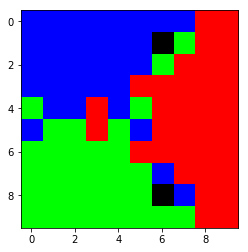

In [22]:
n = 10
domain = complex_space(-2, 2, -2, 2, n, n)
plt.imshow(plot_roots_complex(f, domain, colors))
plt.show()

Even with a low resolution, that took about five seconds to run on my computer. An 800x800 image would take about $\frac{800^2}{10^2} = 6400$ times longer. That is, somewhere in the neighbourhood of eight hours. That's obviously unreasonable.

Now that my code is clear, correct, and functional, I can worry about making it efficient.

## Things to Improve

* Every call to newtons_method requires recomputing the derivative of f and the formula for `next_step`.
    * The [vectorize documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html) says "The `vectorize` function is provided primarily for convenience, not for performance. The implementation is essentially a for loop."
    * `newtons_method` could be rewritten to take a NumPy array of values and only create `f_deriv` and `next_step` once.
* `closest_number` could be rewritten to handle NumPy arrays. It would look something like `numbers[np.argmin(np.abs(numbers - x))]`.
* Right now, `plot_roots_complex` assigns a Python list to a NumPy array (`point_colors[i, j] = colors[root_index]`). This means that an RGB tuple is turned into a NumPy array _for each pixel!_ Try creating the arrays once at the beginning of the function.
* I don't know if sympy.lambdify returns a function that NumPy can compile nicely. Hard-coding `f`, its derivative, and `next_step` might save a lot of computation time.

## Faster!

I won't explain my improved code beyond the above points and the included comments. If you have any questions feel free to ask me in lab or office hours, or by email.

In [23]:
def newtons_method(f, domain, dtype=float, tol=1E-3, max_iters=20):
    """Approximate a root using Newton's method.
    
    Arguments:
        f:         A SymPy function of one variable.
        domain:    A point, or set of points, at which to start Newton's Method.
        dtype:     The type for all values.
        tol:       Maximum distance from zero to consider converged.
        max_iters: Maximum number of iterations to allow.
    
    Returns:
        A NumPy array of approximate roots of f, or numpy.nan if convergence fails.
    """
    # Make sure the domain is a NumPy array.
    domain = np.array(domain, dtype=dtype)
    
    # Local name for the variable.
    x = sp.Dummy('x')
    
    # The iteration in Newton's method, described above.
    next_step = sp.lambdify(x, x - f(x) / sp.diff(f(x), x))
    
    # The derivative of f. Will be used to avoid division by zero.
    # diff returns an expression, not a function, so lambdify is needed again.
    f_deriv = sp.lambdify(x, f(x).diff(x))
    
    # The array which will hold the approximate roots for each starting point.
    roots = np.empty(shape=domain.shape, dtype=dtype)
    
    # Run Newton's Method for each point in domain.
    for domain_i, xi in np.ndenumerate(domain):
        # Iterate at most max_iters times.
        for loop_i in range(max_iters):
            # Check that derivative is not zero, so next x-value is defined.
            if f_deriv(xi) == 0:
                xi = np.nan
                break

            xi = next_step(xi)

            # End iteration if new approximation is close enough to a root.
            # SymPy has an Abs function, but it's an alias for Python's abs.
            if abs(f(xi)) <= tol:
                break
        # If the for loop ran to completion, then the function never got close
        # enough to zero to be a root.
        else:
            xi = np.nan
            
        roots[domain_i] = xi
        
    return roots

In [24]:
def closest_number(x, numbers, dtype=float):
    """Find closest number in a set of numbers.
    
    Arguments:
        x:       Real or complex number to measure distance from.
        numbers: List of real or complex numbers to consider.
        dtype:   The type for all numbers.
        
    Returns:
         A number with minimum distance from x. If multiple numbers are
         equally closest to x, any one could be returned.
    """
    numbers = np.array(numbers, dtype=dtype)
    
    #                        np.abs(numbers - x)   Compute the distance from x to each number
    #              mp.argmin(                   )  Find the index of the minimum value
    #      numbers[                              ] Get the number at that index
    return numbers[np.argmin(np.abs(numbers - x))]

# I only want to vectorize the first argument, so I exclude the second argument (at index 1).
closest_number = np.vectorize(closest_number, excluded=[1])

In [25]:
def plot_roots_complex(f, domain, colors, nonecolor=[0, 0, 0], tol=0.5, max_iters=20):
    """A 2D array of RGB values indicating which root each point converges to.
    
    Arguments:
        f:          A SymPy function of one variable.
        domain:     A point, or list of points, with which to start Newton's Method.
        colors:     A list of RGB triples, at least as many as f has roots.
        nonecolor:  The color for points which don't converge.
        tol:        Maximum distance from zero to consider converged.
        max_iters:  Maximum number of iterations to allow.
        
    Returns:
        A image with the same dimensions as domain.
    """
    # Run Newton's Method and match each result with the closest true root.
    true_roots = np.array(sp.solve(f(x)), dtype=complex)
    approximate_roots = newtons_method(f, domain, dtype=complex, tol=tol, max_iters=max_iters)
    closest_roots = closest_number(approximate_roots, true_roots, dtype=complex)
    
    # colors and nonecolor will be repeatedly inserted into a NumPy array. Making
    # NumPy arrays now will make that process faster.
    colors = np.array(colors)
    nonecolor= np.array(nonecolor)
    
    # point_colors should have the same shape as domain, but with an additional
    # color axis. The color axis must have length 3 for red, green, and blue.
    point_colors = np.ndarray(shape=(*domain.shape, 3))
    
    # It isn't necessary to explicitly unpack the index into i and j. I've done it
    # here for ease of understanding.
    for i, j in np.ndindex(domain.shape):
        root = closest_roots[i, j]
        
        # If the closest root at index (i, j) is None, color it with nonecolor.
        if root is None:
            point_colors[i, j] = nonecolor
        # Otherwise, color it according to the colors argument.
        else:
            # Find the index of the closest true root.
            root_index = np.where(true_roots == root)
            # Use the color at that index.
            point_colors[i, j] = colors[root_index]
            
    return plt.imshow(point_colors)

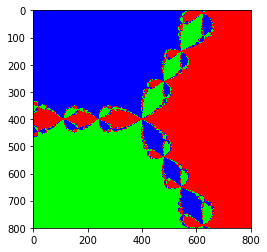

In [26]:
f = sp.lambdify(x, x**3-1)
domain = complex_space(-2, 2, -2, 2, 800, 800)
plot_roots_complex(f, domain, [[1,0,0], [0,1,0], [0,0,1]])
plt.show()

That took about 15 seconds on my computer. There are quite a few ways I could speed up my code, but what I have now is reasonable. I don't want to spend several hours to shave a few seconds off of code that I'll only run a few times.